In [25]:
from sentence_transformers import SentenceTransformer
from sklearn.inspection import PartialDependenceDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from xgboost import XGBClassifier
from xgboost import plot_importance
import optuna
import statsmodels.api as sm
import xgboost as xgb


In [4]:
data = pd.read_excel('/content/processed_data.xlsx')

In [6]:
req_data = data[['Transcript_sentiment',
       'Resume_sentiment', 'JobDescription_sentiment', 'Transcript_words',
       'Resume_words', 'Years_Experience', 'resume_jd_similarity_transformers',
       'transcript_jd_similarity_transformers',
       'transcript_resume_similarity_transformers',
       'resume_sentence_count', 'resume_avg_word_length', 'skill_match_count',
       'university_education_count', 'transcript_vocab_diversity',
       'transcript_avg_sentence_length' , 'decision']]
req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)
x , y = req_data.drop(columns = ['decision' , 'decision_processed']) , req_data['decision_processed']
train_x , test_x , train_y , test_y = train_test_split(x,y,train_size = 0.8 , random_state = 42)

<ipython-input-6-91f2bd361b8a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req_data['decision_processed'] = req_data['decision'].apply(lambda x : 1 if x == 'select' else 0)


In [7]:
train_x += np.random.normal(0, 1e-4, train_x.shape)
test_x += np.random.normal(0, 1e-4, test_x.shape)

In [8]:
import joblib

# Load the model
model = joblib.load('xgb_classifier_model.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:53:03] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [10]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_x)


## **Feature Importance using Beswarm Plot**

#### 1. **Transcript_words**
##### Observation: A higher number of words in the transcript (red points) increases the prediction probability, while fewer words (blue points) decrease it.
##### Impact: Highly positive feature, indicating that longer transcripts are associated with better outcomes.

#### 2. **transcript_avg_sentence_length**
##### Observation: Longer average sentence lengths (red points) tend to slightly increase prediction probabilities. Shorter lengths (blue points) reduce them.
##### Impact: Moderate positive influence, suggesting coherence or richness in sentence structure contributes positively.

#### 3. **JobDescription_sentiment**
##### Observation: Positive sentiment in job descriptions (red points) slightly improves the prediction. Negative sentiment (blue points) reduces it.
##### Impact: A small but meaningful role in aligning candidate attributes with the tone of the job description.

#### 4. **Resume_sentiment**
##### Observation: Resumes with positive sentiment (red points) improve prediction probability, while those with negative sentiment (blue points) lower it.
##### Impact: Moderate positive influence, showing that optimistic or enthusiastic resumes may be more impactful.

#### 5. **university_education_count**
##### Observation: Higher counts (e.g., multiple degrees or certifications, red points) improve prediction. Lower counts (blue points) decrease probability.
##### Impact: Strong positive feature, suggesting higher educational credentials positively influence predictions.

#### 6. **transcript_vocab_diversity**
##### Observation: Higher vocabulary diversity (red points) is associated with higher prediction probabilities. Lower diversity (blue points) reduces it.
##### Impact: Indicates that varied and sophisticated vocabulary in transcripts is advantageous.

#### 7. **resume_jd_similarity_transformers**
##### Observation: Higher similarity scores between the resume and job description (red points) improve prediction probabilities. Lower scores (blue points) reduce them.
##### Impact: Critical feature, suggesting alignment between a candidate's resume and job requirements is vital.

#### 8. **Resume_words**
##### Observation: A higher number of words in resumes (red points) slightly increases prediction probability. Fewer words (blue points) decrease it.
##### Impact: Moderate feature, indicating detailed resumes may perform better.

#### 9. **Years_Experience**
##### Observation: More years of experience (red points) increase prediction probabilities, while fewer years (blue points) decrease them.
##### Impact: Strong positive influence, as experience correlates with job suitability.

#### 10. **transcript_jd_similarity_transformers**
##### Observation: Higher similarity between the transcript and job description (red points) improves predictions, while lower similarity (blue points) decreases them.
##### Impact: Significant feature, emphasizing the importance of aligning communication (e.g., during interviews) with job requirements.

#### 11. **Transcript_sentiment**
##### Observation: Positive sentiment in the transcript (red points) increases prediction probabilities. Negative sentiment (blue points) decreases them.
##### Impact: Moderate role, showing that a positive tone during communication is beneficial.

#### 12. **resume_sentence_count**
##### Observation: Resumes with more sentences (red points) increase prediction probabilities. Fewer sentences (blue points) reduce them.
##### Impact: Indicates that detailed resumes with clear segmentation are advantageous.

#### 13. **resume_avg_word_length**
##### Observation: Longer average word lengths (red points) tend to increase prediction probabilities. Shorter words (blue points) decrease them.
##### Impact: Indicates that using more sophisticated vocabulary positively influences predictions.

#### 14. **skill_match_count**
##### Observation: Higher skill matches (red points) significantly increase prediction probabilities. Fewer matches (blue points) decrease them.
##### Impact: Critical feature, as skill alignment is fundamental to job success.

#### 15. **transcript_resume_similarity_transformers**
##### Observation: Higher similarity between the transcript and resume (red points) improves predictions. Lower similarity (blue points) reduces them.
##### Impact: Important feature, emphasizing consistency between interview communication and the resume.


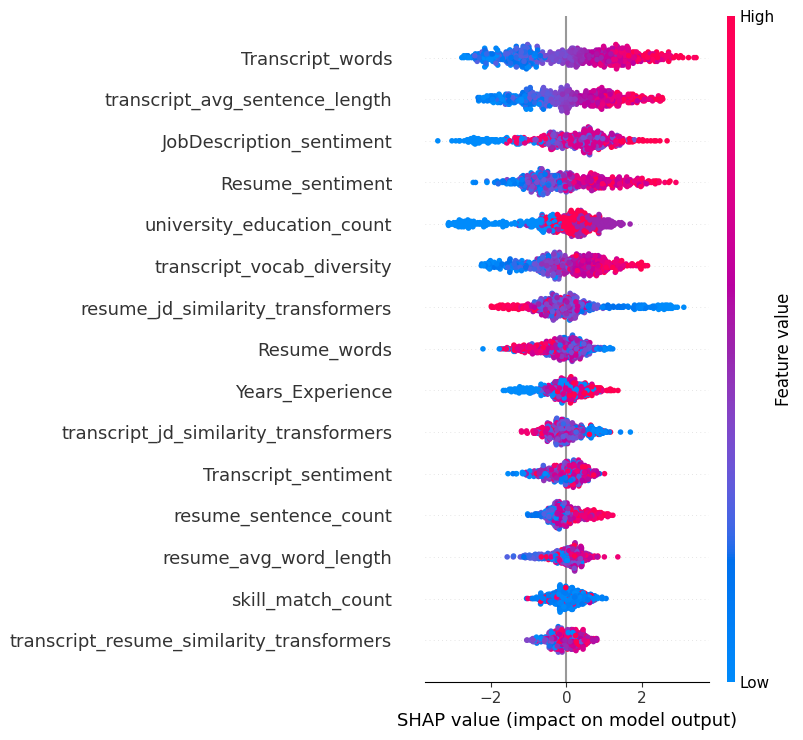

In [11]:
# Beeswarm plot
shap.summary_plot(shap_values, test_x)

# **Waterfall Plot**

In [18]:
# Loading model
import joblib
xgb_model = joblib.load('xgb_classifier_model.pkl')

In [19]:
# Finding the Lowest , middle , high probability predictions from the model
y_pred_xgb = xgb_model.predict(test_x)

In [20]:
low_index = np.argmin(y_pred_xgb)  # Lowest prediction
medium_index = np.argsort(y_pred_xgb)[len(y_pred_xgb) // 2]  # Median prediction
high_index = np.argmax(y_pred_xgb)  # Highest prediction

### **Low prediction**

1. **For low predictions from this water fall plot we can observe that the number of words in transcript are contributing highly negitive  in the prediction of probability for success in interview**

2. **Even the transcript average sentence length
 , resume job description similarity is contributing highly negitive  in the prediction of probability for select in interview**

3. **Transcript job description similarity and  resume sentiment are the only 2 features which are contributing positively but they are also contributing very slightly for increase in the prediction**

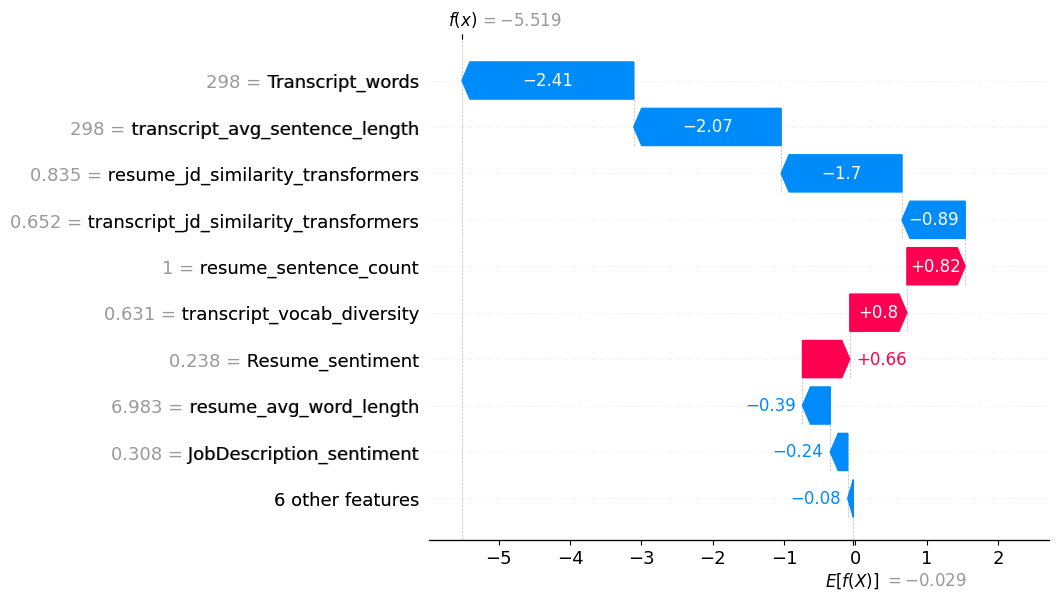

In [21]:
# Waterfall plots
shap.waterfall_plot(shap.Explanation(values=shap_values[low_index],
                                     base_values=explainer.expected_value,
                                     data=test_x.iloc[low_index]),
                    max_display=10)

### **Medium Prediction**

1. **For Medium predictions from this water fall plot we can observe that the number of words in transcript are contributing highly positive(+2.01)  in the prediction of probability for success in interview**

2. **Even the transcript average sentence length
 , resume sentiment is contributing highly positive in the prediction of probability for select in interview**

3. **Transcript vocabulary diversity , resume job descripition similarity using transformers are the ones whuch are contributing negitively  but they are also slightly negitive**

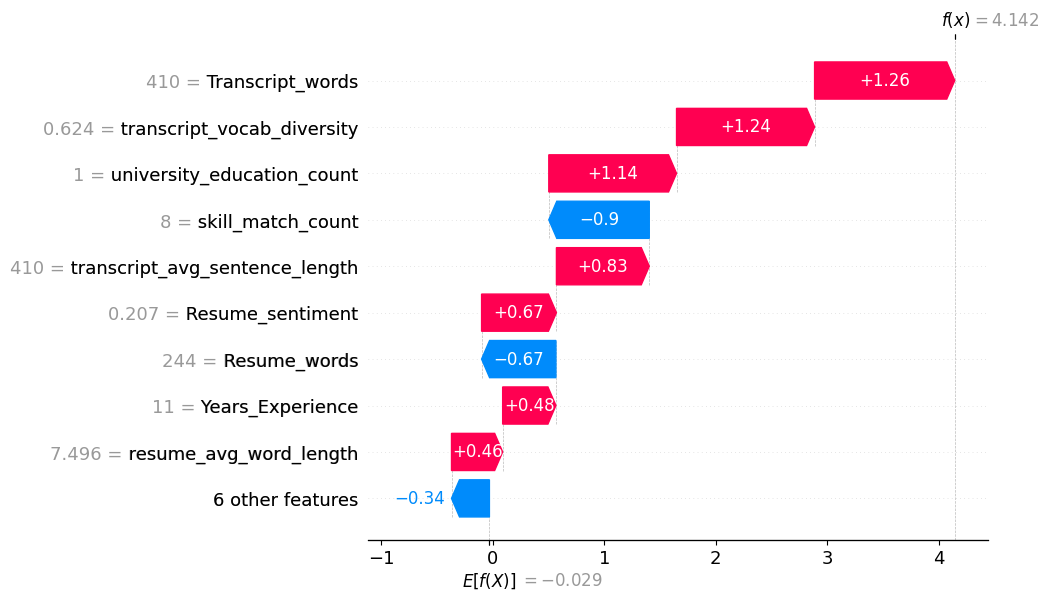

In [22]:
shap.waterfall_plot(shap.Explanation(values=shap_values[medium_index],
                                     base_values=explainer.expected_value,
                                     data=test_x.iloc[medium_index]),
                    max_display=10)

### **High prediction**

1. **For higher predictions from this water fall plot we can observe that the number of words in transcript are contributing highly positive(+2.7) even compared for medium predictions, in the prediction of probability for success in interview**

2. **Even the transcript average sentence length
 , transcript job description similarity , resume sentiment is contributing highly positive in the prediction of probability for select in interview**

3. **Transcript vocabulary diversity is the only feature whuch is contributing negitively  but that contribution is also very slightly (-0.45)**

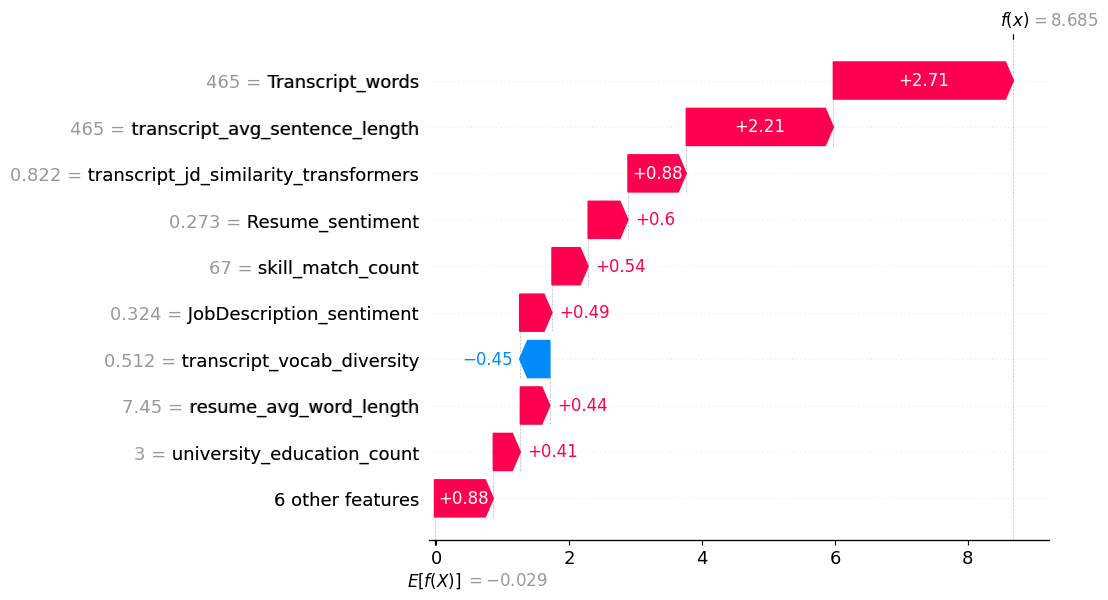

In [23]:
shap.waterfall_plot(shap.Explanation(values=shap_values[high_index],
                                     base_values=explainer.expected_value,
                                     data=test_x.iloc[high_index]),
                    max_display=10)

In [29]:
import pickle

with open("/content/xgb_classifier_model.pkl", "rb") as file:
    model = pickle.load(file)

setattr(model, "use_label_encoder", False)  # Restore the missing attribute
# After loading the model
setattr(model, 'gpu_id', -1)  # Set to -1 if using CPU, or set appropriate value for GPU

# After loading the model
if hasattr(model, 'predictor') is False:
    model._Booster = xgb.Booster(model_file='/content/xgb_model.json')  # Manually set the Booster
    model.predictor = model._Booster  # Set the predictor attribute explicitly


In [30]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['Transcript_words']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['transcript_avg_sentence_length']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


In [ ]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['transcript_vocab_diversity']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()


In [ ]:

# Verify the feature alignment
expected_features = model.feature_names_in_  # Features used in training
train_x = train_x[expected_features]  # Align the features

# Specify features and target class
features_to_plot = ['skill_match_count']  # Indices of the features
target_class = 1  # Specify target class for multi-class PDP

# Generate Partial Dependence Plot
disp = PartialDependenceDisplay.from_estimator(
    xgb_model,
    train_x,
    features=features_to_plot,
    target=target_class,
    feature_names=expected_features,
    kind="average",
    grid_resolution=50
)

plt.suptitle(f"1D Partial Dependence Plots for Class {target_class}")
plt.show()
